In [2]:
import os
import cv2
import math
import torch
import random
import pickle
import numpy as np
import pandas as pd
from typing import Any
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

Loads the spreadsheet

In [3]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent)

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Type Declarations and Helpful Functions

In [4]:
cv2.Image = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get all the contours
def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

# mask and image and return the masked result
def mask_image(img: cv2.Image, lower: tuple[int], upper: tuple[int]) -> cv2.Image:
    mask = cv2.inRange(img, lower, upper)
    return cv2.bitwise_and(img, img, mask=mask)

# draw the contours onto the image
def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

## Segment the leaves from the image

### Approach 1: Use large contours and an image mask

D7860206-18E3-45CC-B3E3-ADCFBD55DF81.jpg


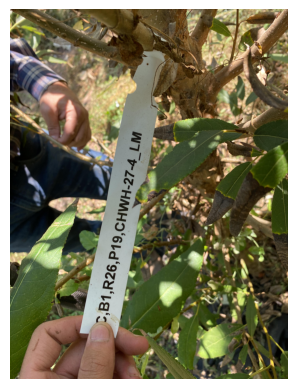

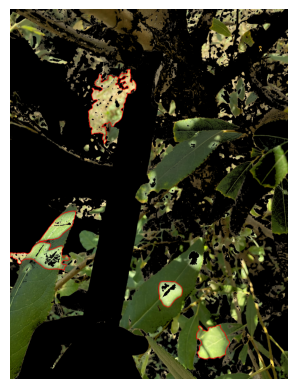

In [4]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(get_contours(masked, False), n=5)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

img = get_image()
get_leaves(img, debug=True)

### Approach 2: Use Canny Edge detection and image inflation to detect contours

6B9F1697-36E1-4350-A4D9-A591AD5744E6.jpg


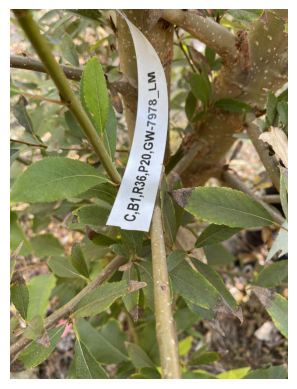

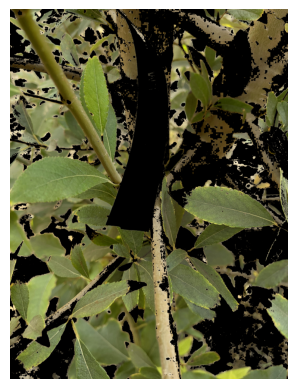

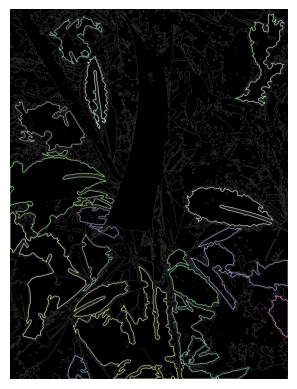

In [9]:
def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    l1, l2 = mask.shape[:2]
    contours = [i[0] for i in filter(
        lambda b: l1 // 16 < b[1][1] and l2 // 16 < b[1][0],
        [(cnt, cv2.boundingRect(cnt)[2:]) for cnt in contours]
    )]
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 15)
    return contours

def get_leaf_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    if debug: imshow(cv2.cvtColor(masked, cv2.COLOR_HSV2BGR))

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    # display found leaves
    if debug:
        drawn_contours = draw_contours(contours, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR))
        imshow(drawn_contours)

    return contours

img = get_image()
_ = get_leaf_contours(img, debug=True)

#### Train a simple ML model to filter leaves

Feature extraction from leaf

3B80C2CA-998D-4004-9260-F28A83E074DF.jpg


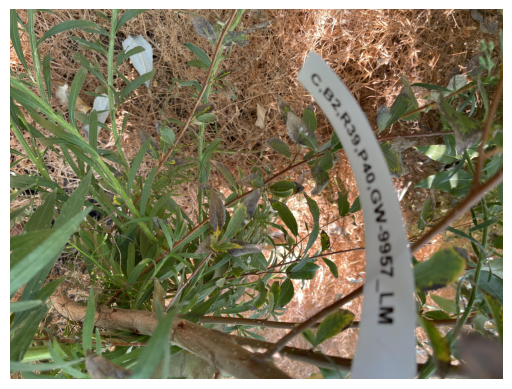

{'area_peri': 0.005968120235923783,
 'area_rect': 0.3406845819363582,
 'area_convex': 0.660515060024441,
 'area_elli_inter': 1.1184476596366248,
 'ellipse_elli_inter': 1.5410368828458076,
 'h0': 0.3778840677338393,
 'h1': 0.8946412160116552,
 'h2': 1.8546222687338465,
 'h3': 2.4432190460453773,
 'h4': 4.678557249806456,
 'h5': 3.183691462753982,
 'h6': 4.833993581304433}

In [11]:
def get_features(contour: cv2.Contour) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    try:
        area_intersect_ratio = area / total_merged_area
        area_ellipse_intersect_ratio = ellipse_area / total_merged_area
    except ZeroDivisionError:
        area_intersect_ratio = area_ellipse_intersect_ratio = 100000  # big number D:

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio
    } | moment_dict    

get_features(get_leaf_contours(get_image())[0])

#### Load ML model to better filter leaves

6B1F72DA-C8A0-40A8-A577-4CB15DE44EE2.jpg


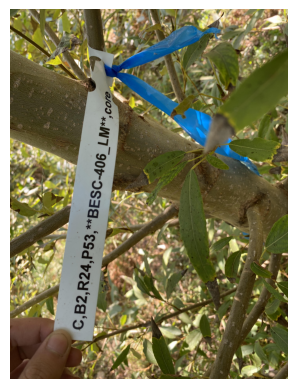

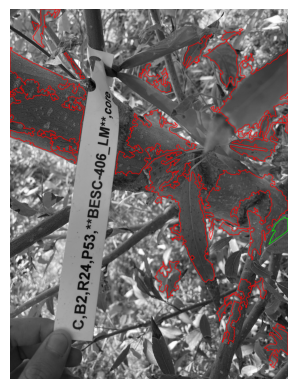

In [12]:
def load_models() -> tuple[RandomForestClassifier, StandardScaler]:
    with open("seg_from_contour/model.pkl", 'rb') as f:
        model = pickle.load(f)
    with open("seg_from_contour/scaler.pkl", 'rb') as f:
        scaler = pickle.load(f)
    return (model, scaler)

# passes contours through a filter to see the real leaves
def find_real_leaf_contours(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> list[cv2.Contour]:
    """ Filters contours through a ML model, returns the 'leaf' contours sorted by highest to lowest confidence """

    CONF_THRESHOLD = 0.70

    # get possible contours, extract features, and predict leaf or not
    contours = get_leaf_contours(img)
    features = scaler.transform(pd.DataFrame([*map(get_features, contours)]))
    predictions = model.predict_proba(features)

    # sift through contours and get the leaves that have the highest chance    
    real_contours, bad_contours = [], []
    for cntr, [_, prob_true] in zip(contours, predictions):
        if prob_true > CONF_THRESHOLD: real_contours.append([cntr, prob_true])
        else: bad_contours.append(cntr)
    sorted_real_contours = [i[0] for i in sorted(real_contours, key=lambda x: x[1], reverse=True)]
    return sorted_real_contours, bad_contours

# loads the ML models and image
model, scaler = load_models()
img = get_image()

# get the contours read and show
good_contours, bad_contours = find_real_leaf_contours(img, model, scaler)
drawn_img = draw_contours(good_contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
drawn_img = draw_contours(bad_contours, drawn_img, mode="red")
imshow(drawn_img)

#### Crop leaves out and do more feature extraction on for next model

B161F6EE-BDA7-47CE-9F00-F20C4812362A.jpg


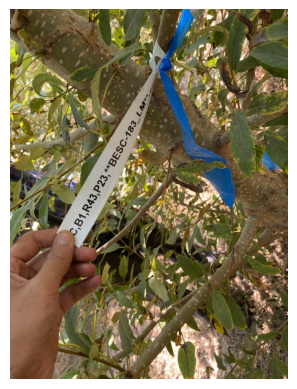

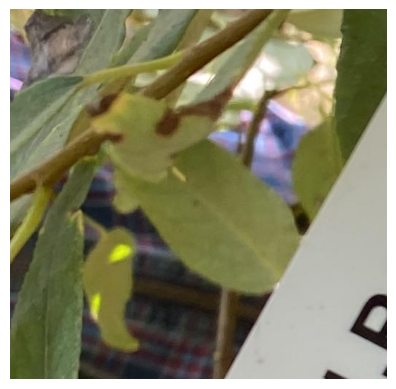

In [20]:
def crop_main_leaf(img: cv2.Image, model: RandomForestClassifier, scaler: StandardScaler) -> cv2.Image:

    EXTRA_SPACE_FACTOR = 0.5

    # assure a leaf is there
    leaves = find_real_leaf_contours(img, model, scaler)[0]
    if not leaves: return None

    # calculate rectangular params
    main_leaf = leaves[random.choice([*range(len(leaves))])]
    x, y, w, h = cv2.boundingRect(main_leaf)

    # calculate adjusted dimensions and angle
    y_min = max(int(y-h*EXTRA_SPACE_FACTOR), 0)
    x_min = max(int(x-w*EXTRA_SPACE_FACTOR), 0)
    y_max = min(int(y+h*(1+EXTRA_SPACE_FACTOR)), len(img))
    x_max = min(int(x+w*(1+EXTRA_SPACE_FACTOR)), len(img[0]))

    # focus on only the area of the leaf in the image
    cropped_img = img[y_min:y_max, x_min:x_max]
    return cropped_img
    
# load model and image
model, scaler = load_models()
img = get_image()

leaf_focus = crop_main_leaf(img, model, scaler)
if leaf_focus is not None: imshow(leaf_focus)

At this point, I realized that this would be too unreliable with simply finding contours

### Approach 3: Use the Segment Anything Model to get the leaves, then filter them based on leaf-ness

Load model and set settings (see `scripts/SAM.[sh|bat]` for model download)

In [7]:
# const information
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_b"
SAM_MODEL_NAME = "sam_vit_b_01ec64.pth"
DATA_PATH = "seg_from_SAM"

# checks for the model being downloaded
if SAM_MODEL_NAME not in os.listdir():
    os.system('cd ..')
    if os.name == 'nt':
        os.system(r".\scripts\SAM.bat")
    else:
        os.system("sh ./scripts/SAM.sh")

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_MODEL_NAME)
sam.to(device=DEVICE)

MODEL = SamAutomaticMaskGenerator(
    model=sam
)

Go through each image and get the segments

In [8]:
# make directories to hold data
if DATA_PATH not in os.listdir():
    os.mkdir(DATA_PATH)
if "images" not in os.listdir(DATA_PATH):
    os.mkdir(f"{DATA_PATH}/images")

# get the segmentation for each image
for filename in SHEET_DATA["filename"]:
    
    # generate masks of the image
    img = get_image(filename, show=False)
    masks = MODEL.generate(img)

    # creates an array to hold the segmentations
    h, w = masks[0]['segmentation'].shape[:2]
    arr = np.zeros((h, w), dtype=np.int64)
    for i, mask in enumerate(masks):
        if mask['area'] < h * w // 500: continue
        arr += mask['segmentation'].astype(np.int64) * i   
    
    cv2.imwrite(f"{DATA_PATH}/images/{filename}", arr)

KeyboardInterrupt: 

Convert the leaves to a list of contours

In [9]:
GREEN_LOWER = (20, 50, 50)
GREEN_UPPER = (80, 255, 255)

# filters the contours frm the segment anything model
# contours -> not too small -> not too far from label -> green avg. color
def filter_contours_from_SAM(img: cv2.Image, mask: cv2.Image) -> list[cv2.Contour]:

    img_h, img_w = img.shape[:2]
    diag_dist = math.sqrt(img_h**2 + img_w**2)

    # obtain the contours from the image
    edged = cv2.Canny(mask, threshold1=0, threshold2=0)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # determine the center point of the white label
    white = cv2.inRange(img, (200, 200, 200), (255, 255, 255))
    white_contour = max(
        cv2.findContours(
            cv2.GaussianBlur(white, (11, 11), sigmaX=0, sigmaY=0),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        ), 
        key=cv2.contourArea
    )
    x, y, w, h = cv2.boundingRect(white_contour)
    center_approx = (y+h//2, x+w//2)

    # filter those that are too far from the center
    close_contours = []
    for contour in contours:
        cx, cy, cw, ch = cv2.boundingRect(contour)
        cntr_center = (cy+ch//2, cx+cw//2)
        if math.sqrt((
            cntr_center[0]-center_approx[0])**2 + (cntr_center[1]-center_approx[1])**2
        ) < diag_dist / 2:
            close_contours.append(contour)
    
    # filter those whose average color are not in the right range
    green_contours = []
    for contour in close_contours:
        leaf_mask = cv2.drawContours(np.zeros((img_h, img_w)), [contour], -1, 255, cv2.FILLED)
        mean_color  = cv2.mean(img, mask=leaf_mask)
        if all([lower < col < upper for lower, col, upper in 
                zip(GREEN_LOWER, mean_color, GREEN_UPPER)]):
            green_contours.append(contour)

    return green_contours

filename = get_random_filename()
img = get_image(filename)
mask = cv2.imread(f"{DATA_PATH}/images/{filename}", cv2.IMREAD_GRAYSCALE)
contours = filter_contours_from_SAM(img, mask)
gray = grayscale(img)
imshow(draw_contours(contours, gray))

SyntaxError: invalid syntax (2692712807.py, line 45)

0C3DBD86-8588-48D6-B90C-AA694592E511.jpg


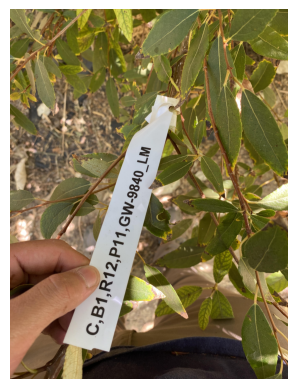

(68.11699779738284, 107.97524220915217, 121.69943281131897, 0.0)

In [10]:
img = get_image()
cv2.mean(img)